# ICLR Workshop Challenge #1: CGIAR Computer Vision for Crop Disease

Amritha Musipatla and Grisam Shah  
CU_sm3773_gvs2110

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports and packages

In [25]:
import os
import csv
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Package to show progress bars on loops
from tqdm import tqdm_notebook as tqdm

from fastai.vision import *
import torchvision.models as tvmodels
from torch.nn.functional import cross_entropy


## Data Observations

Check class distribution in training data.

stem_rust :	 376
healthy_wheat :	 142
leaf_rust :	 358

Total train images:	 876


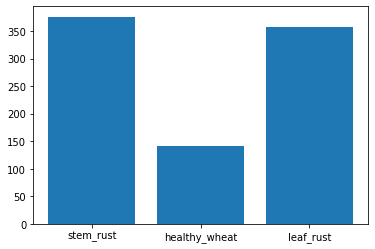

In [3]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

class_dist = {}
total_train = 0

for subdir, dirs, ims in os.walk(train_dir):
    img_list = os.listdir(subdir) 
    number_files = len(img_list)
    
    if (subdir != train_dir):
        print(subdir.split('/')[-1],":\t",number_files)
        total_train = total_train + number_files
        class_dist[subdir.split('/')[-1]] = number_files

print("\nTotal train images:\t", total_train)
    
plt.bar(range(len(class_dist)), class_dist.values(), align='center')
plt.xticks(range(len(class_dist)), list(class_dist.keys()))

plt.show()

Display examples of each class:

stem_rust


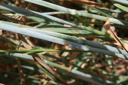

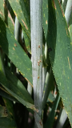

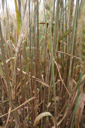

healthy_wheat


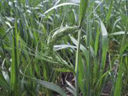

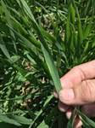

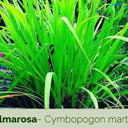

leaf_rust


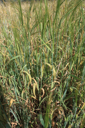

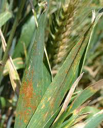

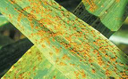

In [4]:
for subdir, dirs, ims in os.walk(train_dir):
    if (subdir != train_dir):
        # Choose random files
        img_list = os.listdir(subdir) 
        number_files = len(img_list)
        img_nums = random.sample(range(number_files), 3)
        print(subdir.split('/')[-1])
        for i in img_nums:
            image = PIL.Image.open(subdir+'/'+img_list[i])
            image.thumbnail([128,128])
            display(image)

## Preprocessing

In this section we format the given train and test image sets to standard form.

In [5]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

# Convert all images to jpg
for subdir, dirs, ims in os.walk(train_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue
            
for subdir, dirs, ims in os.walk(test_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue

Format images as array and reshape to standard size:

In [6]:
def image_to_array(image_path, default_size):
    try:
        im = Image.open(image_path)
        if im is not None:
            out = im.resize(default_size)
            return img_to_array(out)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Set up transforms to augment training dataset.

In [7]:
basic_tfms = get_transforms()

Create training/validation data from df.

In [12]:
train_df = pd.DataFrame(columns=['name','label'])

print("Formatting training images to dataframe...")
for subdir, dirs, ims in os.walk(train_dir):
    for im in ims:
        if im.endswith(".jpg") or im.endswith(".JPG"): 
            im_path = subdir + os.sep + im
            
            if subdir.split('/')[-1] == "healthy_wheat":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["healthy_wheat"]
                                      })
            elif subdir.split('/')[-1] == "stem_rust":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["stem_rust"]
                                      })
            elif subdir.split('/')[-1] == "leaf_rust":
                img_df = pd.DataFrame({"name": im_path,
                                       "label": ["leaf_rust"]
                                      })

            train_df = train_df.append(img_df, sort=True)    
print(train_df)

print("Formatting training dataframe to ImageDataBunch...")
train_data_bunch = ImageDataBunch.from_df(path="./",
                                          df=train_df, 
                                          valid_pct=0.15, 
                                          fn_col="name", 
                                          label_col="label",
                                          size=224,
                                          ds_tfms=basic_tfms)
train_data_bunch.normalize(imagenet_stats)

Formatting training images to dataframe...
        label                             name
0   stem_rust  data/train/stem_rust/QUMDJO.JPG
0   stem_rust  data/train/stem_rust/O03SHZ.jpg
0   stem_rust  data/train/stem_rust/026AEH.JPG
0   stem_rust  data/train/stem_rust/XFVHN1.JPG
0   stem_rust  data/train/stem_rust/3NNNOP.JPG
..        ...                              ...
0   leaf_rust  data/train/leaf_rust/HNDRV1.jpg
0   leaf_rust  data/train/leaf_rust/I11B5N.jpg
0   leaf_rust  data/train/leaf_rust/0W9XLD.JPG
0   leaf_rust  data/train/leaf_rust/5C3950.jpg
0   leaf_rust  data/train/leaf_rust/EANNBM.JPG

[866 rows x 2 columns]
Formatting training dataframe to ImageDataBunch...


ImageDataBunch;

Train: LabelList (737 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: .;

Valid: LabelList (129 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
leaf_rust,stem_rust,healthy_wheat,leaf_rust,stem_rust
Path: .;

Test: None

Create training data from folder.

In [5]:
#data = ImageDataBunch.from_folder(base_dir, test='test', size=224)
#data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Valid: LabelList (537 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Test: LabelList (610 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data

Confirm image integrity by plotting.

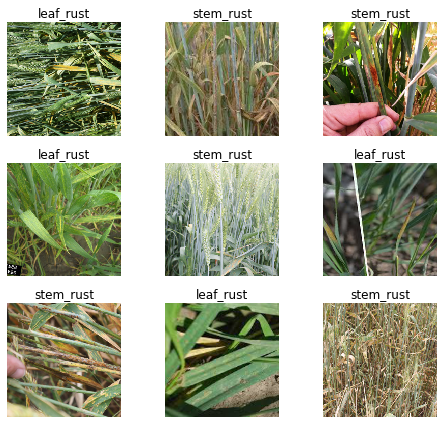

In [13]:
train_data_bunch.show_batch(rows=3, figsize=(7,6))

## Setting up NN model

Create the model: 

In [28]:
learn = cnn_learner(train_data_bunch, models.resnet34, metrics=error_rate)
#learn = cnn_learner(train_data_bunch, tvmodels.resnext50_32x4d, metrics=error_rate)

Hyperparameter tuning: : learning rate.

In [ ]:
learn.lr_find()
learn.recorder.plot()

## Training Model

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,cross_entropy,time
0,1.694088,0.689828,0.689828,03:46
1,1.224955,0.901836,0.901836,03:50
2,1.023219,0.684033,0.684033,03:49


Traceback (most recent call last):
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/amritha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

## Measuring Model

Set up classification interpretation object:

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

Observe "most incorrect".

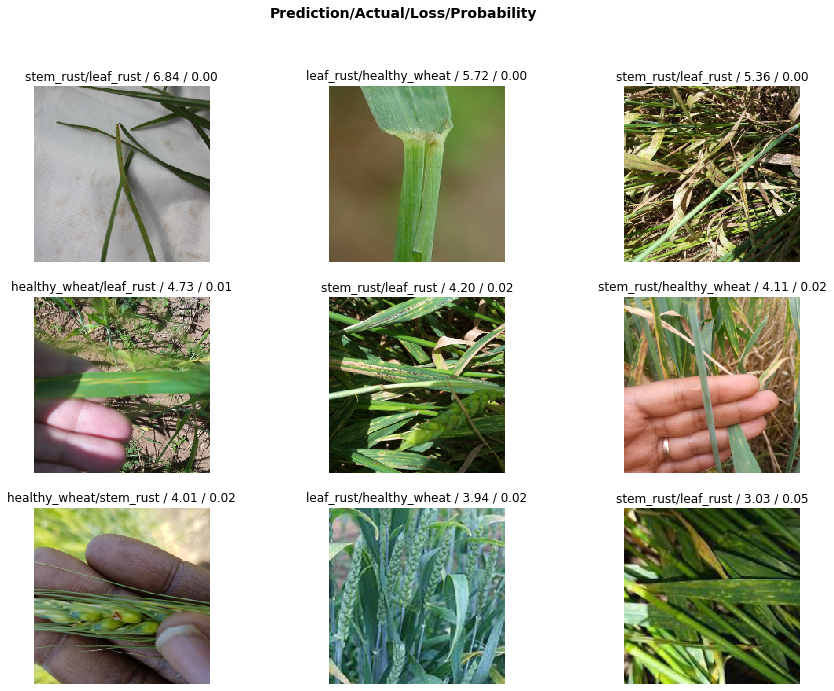

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

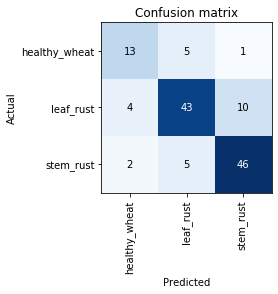

In [18]:
interp.most_confused(min_val=2)
interp.plot_confusion_matrix()

## Making Predictions

Formatting test data:

In [19]:
test_data_bunch = ImageDataBunch.from_folder(base_dir, test='test', size=224)
test_data_bunch.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Valid: LabelList (537 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Test: LabelList (610 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data

Making predictions on test data:

In [20]:
pred_df = pd.DataFrame(columns=['ID','healthy_wheat','leaf_rust','stem_rust'])
num = len(test_data_bunch.test_ds)
print("Total test images:\t", num)

for i in tqdm(range(num)):
    filename = str(test_data_bunch.test_ds.items[i]).split('/')[-1].split('.')[0]
    pred = learn.predict(test_data_bunch.test_ds[i][0])
    df2 = pd.DataFrame({"ID": filename,
                        "healthy_wheat": [pred[2][0].item()],
                        "stem_rust": [pred[2][2].item()],
                        "leaf_rust": [pred[2][1].item()]
                        })
    pred_df = pred_df.append(df2, sort=True)

Total test images:	 610


Print predictions to submission format file. 

In [21]:
print(pred_df)
pred_df.to_csv('submission.csv', index=False)

        ID  healthy_wheat  leaf_rust  stem_rust
0   1WP5MJ       0.393126   0.174182   0.432692
0   C3LIDU       0.045513   0.857981   0.096506
0   OS8FB2       0.000288   0.000824   0.998888
0   NS8DVC       0.330019   0.669416   0.000564
0   2G71YU       0.643501   0.296734   0.059764
..     ...            ...        ...        ...
0   Y7VVJU       0.998918   0.000995   0.000088
0   D6TACK       0.051060   0.948829   0.000111
0   UIPPYH       0.004352   0.000128   0.995521
0   BE0SDD       0.000234   0.999608   0.000159
0   UGQ06J       0.086860   0.143079   0.770061

[610 rows x 4 columns]
